In [1]:
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
import urllib
%matplotlib inline

In [15]:
# The kernal of HANTS algorithm. Implemented by Mattijn.
def makediag3d(M):
    b = np.zeros((M.shape[0], M.shape[1] * M.shape[1]))
    b[:, ::M.shape[1] + 1] = M
    
    #logging.info('function `makediag3d` complete')    
    return b.reshape(M.shape[0], M.shape[1], M.shape[1]) 

def get_starter_matrix(base_period_len, sample_count, frequencies_considered_count):
    nr = min(2 * frequencies_considered_count + 1,
                  sample_count)  # number of 2*+1 frequencies, or number of input images
    mat = np.zeros(shape=(nr, sample_count))
    mat[0, :] = 1
    ang = 2 * np.pi * np.arange(base_period_len) / base_period_len
    cs = np.cos(ang)
    sn = np.sin(ang)
    # create some standard sinus and cosinus functions and put in matrix
    i = np.arange(1, frequencies_considered_count + 1)
    ts = np.arange(sample_count)
    for column in xrange(sample_count):
        index = np.mod(i * ts[column], base_period_len)
        # index looks like 000, 123, 246, etc, until it wraps around (for len(i)==3)
        mat[2 * i - 1, column] = cs.take(index)
        mat[2 * i, column] = sn.take(index)

    #logging.info('HANTS: function `get_starter_matrix` complete')
    return mat

def HANTS(sample_count, inputs,
          frequencies_considered_count=3,
          outliers_to_reject='Lo',
          low=0., high=255,
          fit_error_tolerance=5,
          dod = 5,
          delta=0.1):
    """
    Function to apply the Harmonic analysis of time series applied to arrays

    sample_count    = nr. of images (total number of actual samples of the time series)
    base_period_len    = length of the base period, measured in virtual samples
            (days, dekads, months, etc.)
    frequencies_considered_count    = number of frequencies to be considered above the zero frequency
    inputs     = array of input sample values (e.g. NDVI values)
    ts    = array of size sample_count of time sample indicators
            (indicates virtual sample number relative to the base period);
            numbers in array ts maybe greater than base_period_len
            If no aux file is used (no time samples), we assume ts(i)= i,
            where i=1, ..., sample_count
    outliers_to_reject  = 2-character string indicating rejection of high or low outliers
            select from 'Hi', 'Lo' or 'None'
    low   = valid range minimum
    high  = valid range maximum (values outside the valid range are rejeced
            right away)
    fit_error_tolerance   = fit error tolerance (points deviating more than fit_error_tolerance from curve
            fit are rejected)
    dod   = degree of overdeterminedness (iteration stops if number of
            points reaches the minimum required for curve fitting, plus
            dod). This is a safety measure
    delta = small positive number (e.g. 0.1) to suppress high amplitudes
    """
    # logger = mp.get_logger()
    # logger.info('HANTS: HANTS is active %s', inputs.shape)

    # define some parameters
    base_period_len = sample_count  #
    
    # check which setting to set for outlier filtering
    if outliers_to_reject == 'Hi':
        sHiLo = -1
    elif outliers_to_reject == 'Lo':
        sHiLo = 1
    else:
        sHiLo = 0

    nr = min(2 * frequencies_considered_count + 1,
             sample_count)  # number of 2*+1 frequencies, or number of input images

    # create empty arrays to fill
    outputs = np.zeros(shape=(inputs.shape[0], sample_count))

    mat = get_starter_matrix(base_period_len, sample_count, frequencies_considered_count)

    # repeat the mat array over the number of arrays in inputs
    # and create arrays with ones with shape inputs where high and low values are set to 0
    mat = np.tile(mat[None].T, (1, inputs.shape[0])).T
    p = np.ones_like(inputs)
    p[(low >= inputs) | (inputs > high)] = 0
    nout = np.sum(p == 0, axis=-1)  # count the outliers for each timeseries


    # prepare for while loop
    ready = np.zeros((inputs.shape[0]), dtype=bool)  # all timeseries set to false

    #dod = 1  # (2*frequencies_considered_count-1)  # Um, no it isn't :/
    noutmax = sample_count - nr - dod
    # prepare to add delta to suppress high amplitudes but not for [0,0]
    Adelta = np.tile(np.diag(np.ones(nr))[None].T, (1, inputs.shape[0])).T * delta
    Adelta[:, 0, 0] -= delta
    
    
    for _ in xrange(sample_count):
        if ready.all():
            break        
        
        # multiply outliers with timeseries
        za = np.einsum('ijk,ik->ij', mat, p * inputs)
        #print za

        # multiply mat with the multiplication of multiply diagonal of p with transpose of mat
        diag = makediag3d(p)
        #print diag
        
        A = np.einsum('ajk,aki->aji', mat, np.einsum('aij,jka->ajk', diag, mat.T))
        # add delta to suppress high amplitudes but not for [0,0]
        A += Adelta
        #A[:, 0, 0] = A[:, 0, 0] - delta
        #print A

        # solve linear matrix equation and define reconstructed timeseries
        zr = np.linalg.solve(A, za)
        #print zr
        
        outputs = np.einsum('ijk,kj->ki', mat.T, zr)
        #print outputs

        # calculate error and sort err by index
        err = p * (sHiLo * (outputs - inputs))
        rankVec = np.argsort(err, axis=1, )

        # select maximum error and compute new ready status
        maxerr = np.max(err, axis=-1)
        #maxerr = np.diag(err.take(rankVec[:, sample_count - 1], axis=-1))
        ready = (maxerr <= fit_error_tolerance) | (nout == noutmax)        

        # if ready is still false
        if not ready.all():
            j = rankVec.take(sample_count - 1, axis=-1)

            p.T[j.T, np.indices(j.shape)] = p.T[j.T, np.indices(j.shape)] * ready.astype(
                int)  #*check
            nout += 1

    #logging.info('HANTS: function `HANTS` complete')
    #print 'function HANTS complete'
    return outputs

In [2]:
url = 'http://192.168.1.104:8080/rasdaman/ows/wcs?query=for%20c%20in%20%28NDVI_MOD13C1005_uptodate%29%20return%20encode%28%20scale%28%20c[ansi%28147192:147558%29,Lat%2850%29,Long%2860:80%29],{ansi%28147192:147558%29,Long%280:20%29}%29,%22netcdf%22%29'
path_org = 'test.nc'
f,h = urllib.urlretrieve(url, path_org)
ds_org = gdal.Open('NETCDF:'+path_org+':Band1')
array_org = ds_org.ReadAsArray()

In [29]:
array_org1 = np.array([[6198, 6141, 6400, 5440, 6310, 7101, 7239, 6606, 6628, 8549, 7588, 7655, 7296, 7329
, 7348, 7288, 7261, 7067, 6809, 6552, 5201]
, [6180, 6230, 6190, 5743, 6406, 7057, 7298, 6764, 6956, 8662, 7280, 8140, 7600, 7633
, 7593, 7472, 7426, 7209, 7074, 6736, 5558]
, [6522, 6812, 2889, 6548, 7359, 7833, 8182, 7362, 7638, 8560, 7069, 8542, 8093, 8514
, 8222, 8167, 7981, 7790, 7483, 7231, 6320]
, [6575, 6651, 1167, 6840, 7288, 7785, 7920, 7354, 7278, 8271, 7027, 8575, 8065, 8146
, 8156, 8166, 8010, 7742, 7521, 7253, 6319]
, [6928, 6686, 1470, 6885, 7531, 7846, 7873, 7372, 7619, 8132, 7545, 8588, 8114, 8491
, 8286, 8177, 7946, 7774, 7508, 7244, 6076]
, [7008, 6613, 2907, 6974, 7436, 7810, 7755, 7243, 7454, 8332, 7635, 8327, 7975, 8325
, 8158, 8056, 7761, 7719, 7487, 7162, 5848]
, [6685, 6582, 4204, 6322, 6856, 7202, 7234, 7765, 7752, 7802, 7629, 8122, 7971, 8286
, 8074, 7912, 7923, 7638, 7311, 7039, 6084]
, [6974, 6854, 2447, 6031, 6718, 7255, 7649, 7959, 8339, 8060, 6330, 8394, 8207, 8402
, 8366, 8196, 8096, 7679, 6998, 7148, 6293]
, [6869, 3006, 1690, 6209, 6923, 7488, 7501, 7747, 8039, 7662, 7600, 8214, 8050, 8275
, 8237, 8046, 8051, 7704, 7037, 7266, 6098]
, [6933, 2724, 1716, 6483, 7339, 7942, 6818, 7438, 7594, 7391, 7934, 7992, 7733, 8136
, 8109, 7888, 7975, 7746, 7076, 7300, 6018]
, [7080, 2445, 5103, 6447, 7309, 8011, 7388, 7544, 7983, 7864, 8008, 7972, 7747, 8348
, 8120, 7898, 8007, 7794, 6708, 7401, 6180]
, [7065, 3297, 6554, 5838, 6420, 6975, 5858, 8294, 8302, 8033, 8598, 8257, 8252, 8463
, 8359, 8036, 8108, 7556, 6843, 7282, 6637]
, [6672, 3980, 5982, 6145, 6613, 7176, 4357, 7659, 7802, 6627, 7975, 8077, 7953, 7779
, 8163, 7932, 7835, 7358, 4287, 7269, 5630]
, [6232, 4882, 6134, 5960, 6312, 7092, 5764, 7738, 8078, 7792, 8399, 7639, 7432, 6264
, 7568, 7285, 7371, 7033, 6146, 6730, 5530]
, [5762, 4276, 5829, 5654, 6150, 6887, 5263, 7528, 7851, 7901, 7194, 6546, 6424, 6225
, 6614, 6243, 6368, 6411, 6649, 6126, 4837]
, [5577, 5447, 5563, 5264, 5851, 6600, 6568, 7907, 8094, 8153, 7230, 6261, 6306, 6300
, 6481, 6088, 6234, 6317, 6558, 6012, 4805]
, [5487, 5716, 5390, 5296, 6036, 6945, 6743, 7562, 7804, 7867, 6475, 5598, 5471, 5101
, 5475, 5159, 5580, 5782, 6133, 5673, 3993]
, [4489, 4725, 4286, 4404, 5157, 6389, 6477, 6635, 7232, 7865, 7414, 5400, 4905, 4560
, 4799, 4512, 4622, 4722, 5216, 4775, 3162]
, [4875, 5024, 4612, 4630, 5481, 6650, 6293, 6854, 7692, 7983, 6994, 5936, 5452, 5021
, 5444, 5216, 5226, 5133, 5595, 4943, 3708]
, [4324, 4546, 4209, 4300, 4900, 6338, 6043, 6586, 7756, 7858, 6919, 5803, 5251, 5423
, 5268, 4845, 5004, 4945, 5278, 4593, 3487]
, [4309, 4432, 4322, 4448, 5006, 6453, 6179, 6599, 7543, 7878, 7049, 6002, 5220, 5992
, 5368, 4831, 5100, 5017, 5508, 4786, 3583]
, [4209, 4656, 4342, 4252, 4760, 5895, 4858, 6232, 7388, 7567, 6763, 6096, 5352, 6136
, 5670, 5161, 5368, 5159, 5426, 4622, 2502]
, [4140, 4248, 4208, 4088, 4597, 5307, 6103, 6203, 7385, 7730, 7275, 6410, 5716, 6404
, 5915, 5556, 5441, 5208, 5282, 4650, 2731]
, [5064, 5236, 4993, 4849, 5177, 5790, 6967, 7169, 7802, 8214, 7940, 7160, 6715, 6861
, 6609, 6055, 5947, 5893, 6051, 5329, 3869]
, [6277, 5755, 6013, 5804, 5787, 6139, 7130, 7948, 8365, 8279, 8248, 8092, 7828, 7707
, 7874, 7611, 7498, 7416, 6346, 6444, 5749]
, [5066, 5013, 5109, 4861, 4893, 5306, 6086, 6617, 6800, 6853, 6843, 6822, 6533, 6619
, 6717, 6450, 6639, 6514, 6094, 5625, 4578]
, [3855, 4467, 4376, 4150, 4532, 5139, 5898, 6260, 6331, 4766, 6166, 6023, 6013, 6104
, 5822, 5835, 5762, 5469, 4890, 4462, 3580]
, [5108, 5316, 5295, 5077, 5388, 6434, 7063, 7230, 7644, 5647, 7323, 7226, 7073, 6991
, 6944, 6760, 6988, 6680, 6007, 5492, 4299]
, [5376, 4424, 4582, 5458, 5610, 6632, 7371, 7383, 7764, 6065, 7397, 7178, 6852, 6655
, 6614, 6623, 6543, 6583, 5357, 5790, 4139]
, [5857, 2161, 5010, 5954, 6291, 7070, 7534, 7455, 7752, 6955, 7384, 7332, 7084, 7236
, 7192, 7064, 6945, 6881, 4810, 6172, 4683]
, [6514, 1459, 6760, 6602, 6998, 7256, 7877, 7642, 8079, 7796, 7807, 8097, 7766, 8114
, 7875, 7783, 7677, 7560, 4201, 6850, 5541]])

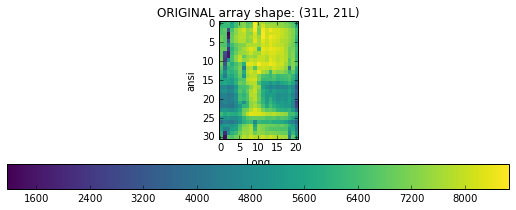

In [31]:
fig = plt.figure(figsize=(15,3))

ax2 = fig.add_subplot(111)
img2 = ax2.imshow(np.ma.masked_equal(array_org1, 0), cmap='viridis',interpolation = 'nearest')
ax2.set_xlabel('Long')
ax2.set_ylabel('ansi')
ax2.set_title('ORIGINAL array shape: '+str(array_org1.shape))

plt.colorbar(img2, orientation='horizontal', ax=ax2)
plt.tight_layout()
#plt.savefig(r'D:\tmp\HANTS_OUT//slice_ansi_long.png', dpi=200)
plt.show()

In [38]:
array_hants = HANTS(array_org1.shape[1], array_org1/100.,
                    frequencies_considered_count = 3,
                    outliers_to_reject = 'Lo',
                    low = -10000/100., 
                    high = 10000/100.,
                    fit_error_tolerance = 500/100.,
                    dod = 5/100.,
                    delta = 0.1)
array_hants *= 100

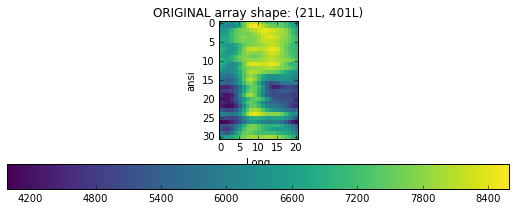

In [39]:
fig = plt.figure(figsize=(15,3))

ax2 = fig.add_subplot(111)
img2 = ax2.imshow(np.ma.masked_equal(array_hants, 0), cmap='viridis',interpolation = 'nearest')
ax2.set_xlabel('Long')
ax2.set_ylabel('ansi')
ax2.set_title('ORIGINAL array shape: '+str(array_org.shape))

plt.colorbar(img2, orientation='horizontal', ax=ax2)
plt.tight_layout()
#plt.savefig(r'D:\tmp\HANTS_OUT//slice_ansi_long.png', dpi=200)
plt.show()

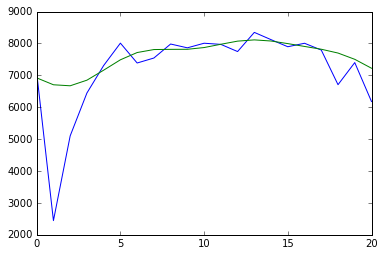

In [40]:
plt.plot(array_org1[10])
plt.plot(array_hants[10])

In [185]:
a = np.array([[0,0,3],[4,5,6],[7,0,0],[10,11,12],[13,14,15]])
b = np.zeros_like(a)
a

array([[ 0,  0,  3],
       [ 4,  5,  6],
       [ 7,  0,  0],
       [10, 11, 12],
       [13, 14, 15]])

In [188]:
# select all rows containg note more than 50% 0 values
percent = np.sum(a == 0, axis=-1) / float(check.shape[1])
percent = percent >= 0.5
slice = np.invert(percent).nonzero()[0][0:2]

In [189]:
# select first two rows satisfying 'slice'
a[slice]

array([[ 4,  5,  6],
       [10, 11, 12]])

In [190]:
# do something and place modified rows on same index of zero array
b[slice] = a[slice] * 2

In [191]:
b

array([[ 0,  0,  0],
       [ 8, 10, 12],
       [ 0,  0,  0],
       [20, 22, 24],
       [ 0,  0,  0]])

In [192]:
import base64
import uuid
# get a UUID - URL safe, Base64
def get_a_uuid():
    r_uuid = base64.urlsafe_b64encode(uuid.uuid4().bytes)
    return r_uuid.replace('=', '')

In [285]:
get_a_uuid()

'emIL2mskTqWvR1yfks5eMQ'